# Daten laden

## Peeringdb Daten laden

In [14]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

bgp_df = pd.read_csv('/home/jhart/asn-classifier/scripts/as_metrics_with_rpki.csv')
net_df = net_df.merge(bgp_df, on='asn', how='inner')

# show a quick preview
len(net_df), net_df.head()

(20984,
    id  org_id                         name  \
 0   1    8897  GTT Communications (AS4436)   
 1   2      14          Akamai Technologies   
 2   3      17           DALnet IRC Network   
 3   5    9350                     Swisscom   
 4   6      23           Cox Communications   
 
                                        aka name_long  \
 0  Formerly known as nLayer Communications             
 1                                                      
 2                                                      
 3                                  IP-Plus             
 4                       Cox Communications             
 
                       website  \
 0          http://www.gtt.net   
 1     https://www.akamai.com/   
 2          http://www.dal.net   
 3     http://www.swisscom.com   
 4  http://www.cox.com/peering   
 
                                         social_media    asn looking_glass  \
 0  [{'service': 'website', 'identifier': 'http://...   4436                 
 1

## AS Rank laden

In [15]:
as_rank_df = pd.read_csv('../../preprocessing/data/asrank/as_rank_df.csv')
as_rank_df.head()

,asn,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,3356,1,6613,6545,68,0,53986,873410,3468642119
1,1299,2,2567,2509,58,0,41193,776707,3219679484
2,174,3,6723,6626,97,0,38887,730166,3034352967
3,3257,4,1853,1816,37,0,36040,612491,2791999209
4,2914,5,1541,1483,58,0,25179,576134,2918763154


## Daten Mergen

In [16]:
merged_df = pd.merge(net_df, as_rank_df, left_on='asn', right_on='asn', how='left')
merged_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,rpki_total,rpki_valid_share,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,0,0.000000,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,4848,0.991749,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,2,1.000000,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,407,0.891892,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,5418,0.982835,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0


# Evaluation

/tmp/ipykernel_742562/1746681462.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_742562/1746681462.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(order, rotation=45)
/tmp/ipykernel_742562/1746681462.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_742562/1746681462.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(order, rotation=45)


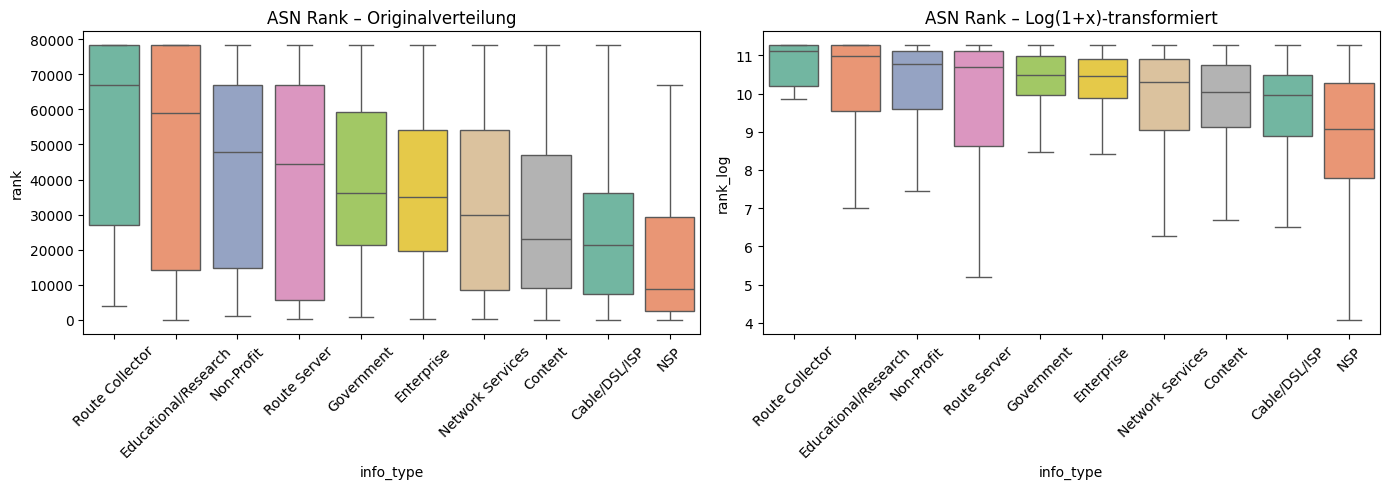

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Log-Spalte hinzufügen (falls noch nicht vorhanden)
merged_df["rank_log"] = np.log1p(merged_df["rank"])

# Reihenfolge der Klassen nach Median des Rohwertes
order = merged_df.groupby('info_type')['rank'].median().sort_values(ascending=False).index

# Figure mit 2 Plots nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Originalwerte ---
sns.boxplot(
    data=merged_df,
    x='info_type',
    y='rank',
    order=order,
    ax=axes[0],
    palette="Set2",
    showfliers=False
)
axes[0].set_title("ASN Rank – Originalverteilung")
axes[0].set_xticklabels(order, rotation=45)

# --- Log-transformiert ---
sns.boxplot(
    data=merged_df,
    x='info_type',
    y='rank_log',
    order=order,
    ax=axes[1],
    palette="Set2",
    showfliers=False
)
axes[1].set_title("ASN Rank – Log(1+x)-transformiert")
axes[1].set_xticklabels(order, rotation=45)

plt.tight_layout()
plt.show()

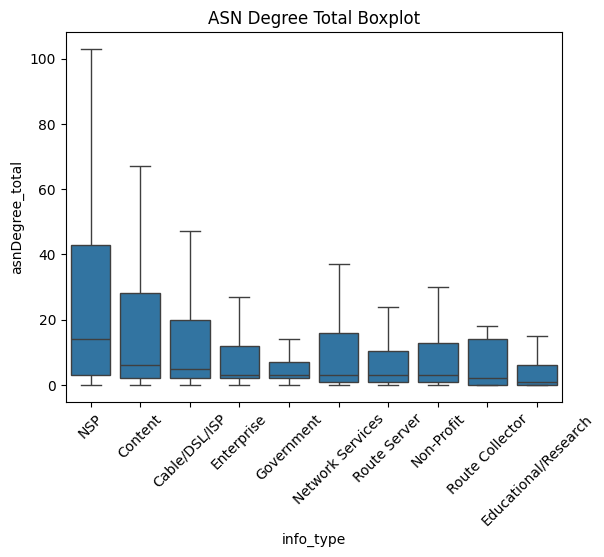

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
order = merged_df.groupby('info_type')['asnDegree_total'].median().sort_values(ascending=False).index
sns.boxplot(data=merged_df, x='info_type', y='asnDegree_total', order=order, showfliers=False)
plt.xticks(rotation=45)
plt.title('ASN Degree Total Boxplot')
plt.show()


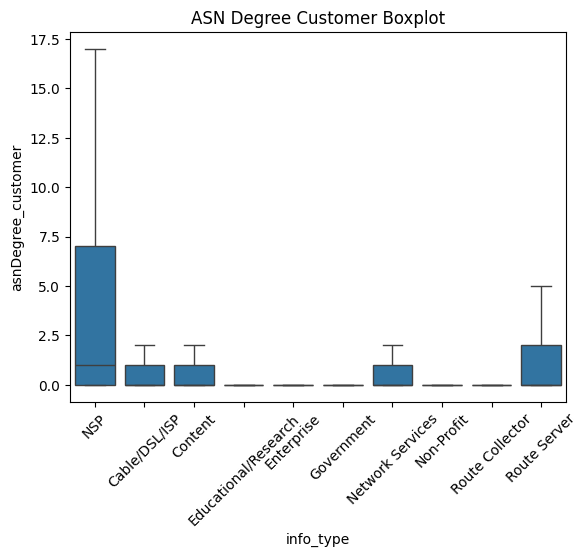

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
order = merged_df.groupby('info_type')['asnDegree_customer'].median().sort_values(ascending=False).index
sns.boxplot(data=merged_df, x='info_type', y='asnDegree_customer', order=order, showfliers=False)
plt.xticks(rotation=45)
plt.title('ASN Degree Customer Boxplot')
plt.show()


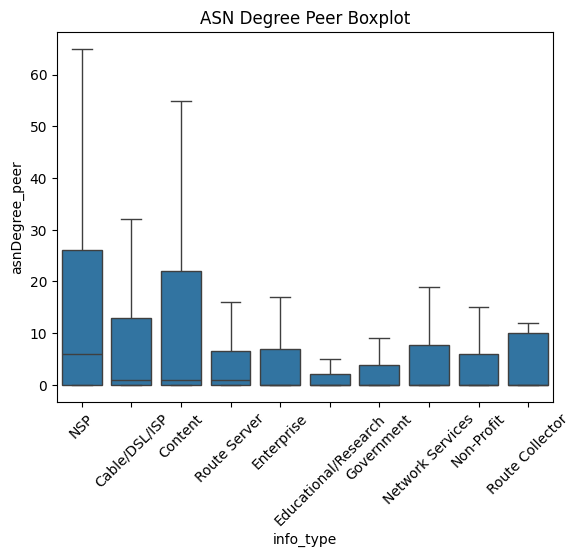

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
order = merged_df.groupby('info_type')['asnDegree_peer'].median().sort_values(ascending=False).index
sns.boxplot(data=merged_df, x='info_type', y='asnDegree_peer', order=order, showfliers=False)
plt.xticks(rotation=45)
plt.title('ASN Degree Peer Boxplot')
plt.show()


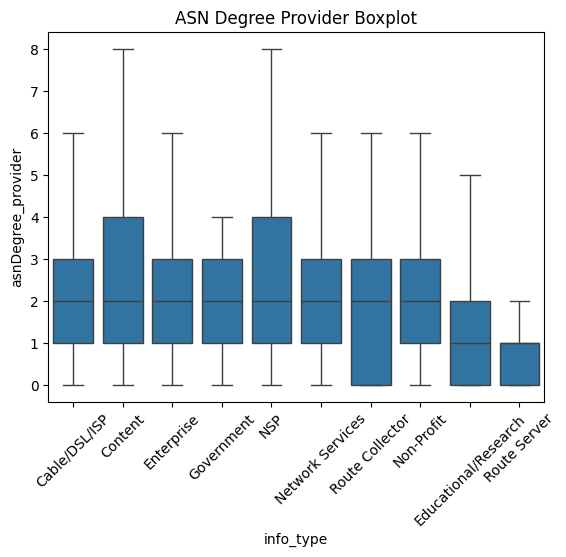

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
order = merged_df.groupby('info_type')['asnDegree_provider'].median().sort_values(ascending=False).index
sns.boxplot(data=merged_df, x='info_type', y='asnDegree_provider', order=order, showfliers=False)
plt.xticks(rotation=45)
plt.title('ASN Degree Provider Boxplot')
plt.show()


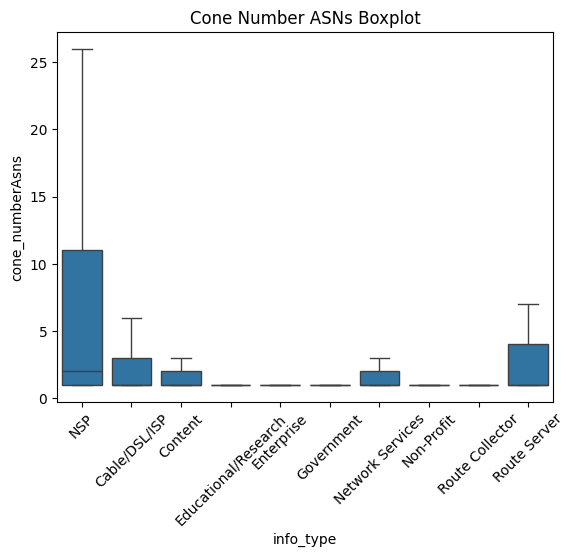

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
order = merged_df.groupby('info_type')['cone_numberAsns'].median().sort_values(ascending=False).index
sns.boxplot(data=merged_df, x='info_type', y='cone_numberAsns', order=order, showfliers=False)
plt.xticks(rotation=45)
plt.title('Cone Number ASNs Boxplot')
plt.show()


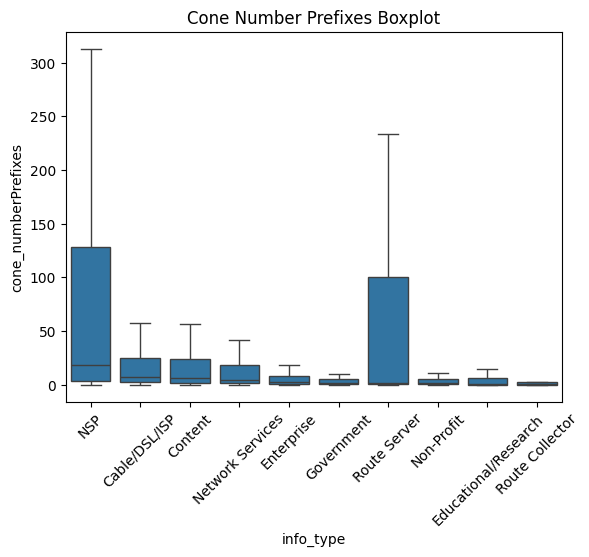

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
order = merged_df.groupby('info_type')['cone_numberPrefixes'].median().sort_values(ascending=False).index
sns.boxplot(data=merged_df, x='info_type', y='cone_numberPrefixes', order=order, showfliers=False)
plt.xticks(rotation=45)
plt.title('Cone Number Prefixes Boxplot')
plt.show()


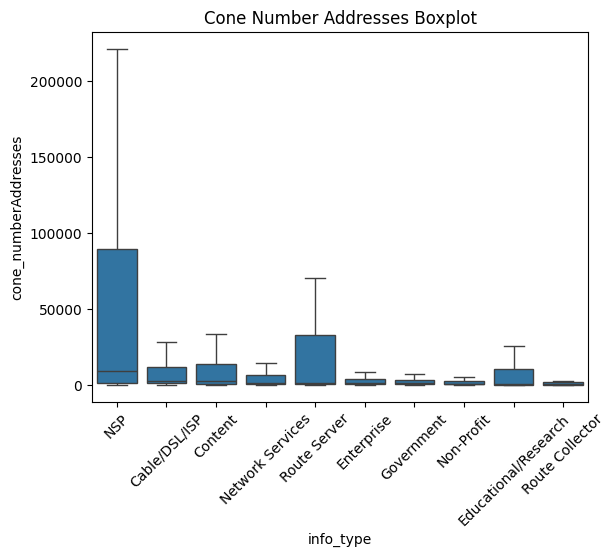

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
order = merged_df.groupby('info_type')['cone_numberAddresses'].median().sort_values(ascending=False).index
sns.boxplot(data=merged_df, x='info_type', y='cone_numberAddresses', order=order, showfliers=False)
plt.xticks(rotation=45)
plt.title('Cone Number Addresses Boxplot')
plt.show()
